In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# === Paths ===
path_in = os.path.join("../Data")  # parent directory
list_file_names = [f for f in os.listdir(path_in) if f.startswith("blg_")]

# === Dictionary to store DataFrames ===
dataframes = {}

# === Loop through files ===
for file in list_file_names:
    file_path = os.path.join(path_in, file)
    
    # Read file
    df = pd.read_csv(file_path, sep=";", header=0)
    
    # Drop 'Unnamed: 0' if exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Multiply 'Ps' and 'Thm' by 1000 if they exist
    for col in ['Ps', 'Thm']:
        if col in df.columns:
            df[col] = df[col] * 1000

    # Rename columns
    rename_mapping = {
        'Ta': 'OUTDOOR_TEMP',
        'yTi': 'INDOOR_TEMP',
        'Thm': 'PHI_H',
        'Ps': 'PYRANOMETER'
    }
    df = df.rename(columns=rename_mapping)

    # Convert 't' to datetime and set as index
    df['t'] = pd.to_datetime(df['t'])
    df = df.set_index('t')

    # Resample to 30 minutes
    df = df.resample('30min').mean()

    # Bring back 't' as a column if needed
    df = df.reset_index()

    # Save into dictionary
    key_name = os.path.splitext(file)[0]
    dataframes[key_name] = df

surface_area = 400000  # m² 


In [2]:
split_index = int(0.8 * 0.4*len(dataframes['blg_1']))
end_index = int(0.4*len(dataframes['blg_1'])) 
train_df = dataframes['blg_1'].iloc[:split_index]
val_df = dataframes['blg_1'].iloc[split_index:end_index]

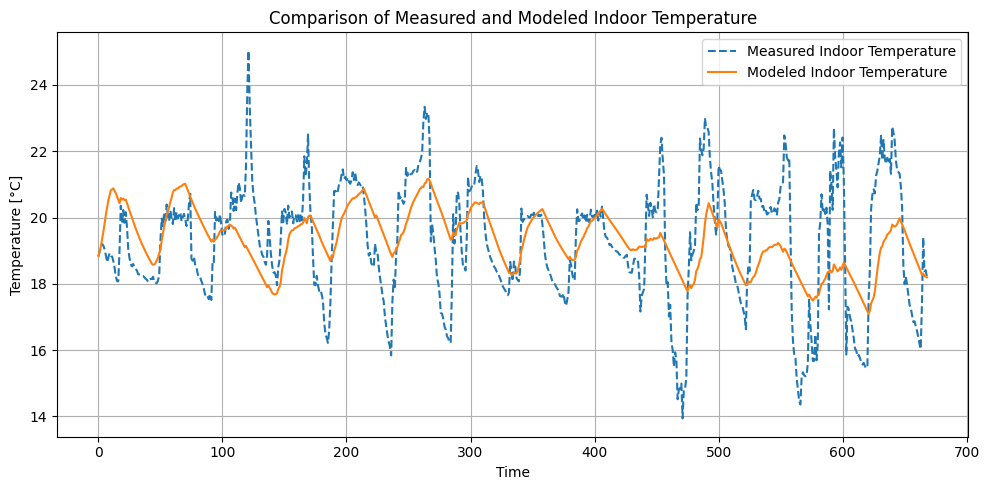

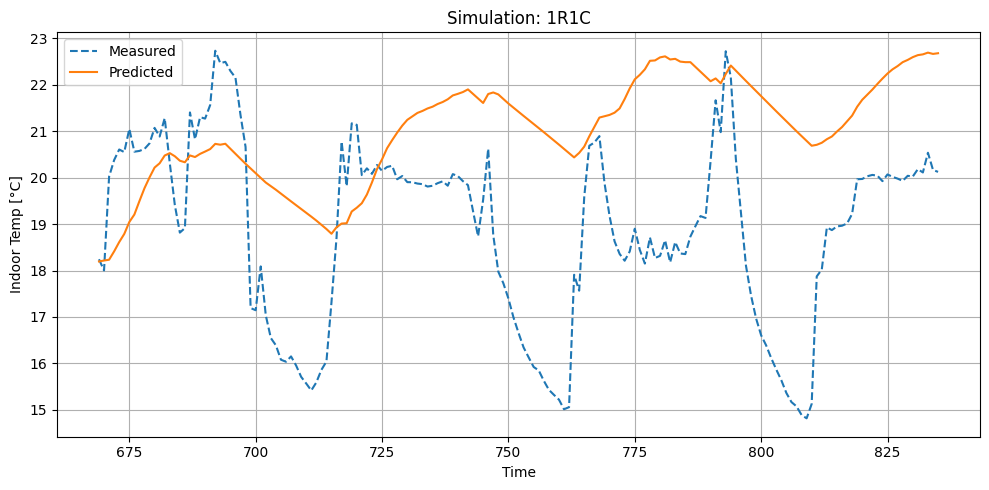

Validation RMSE: 3.0246


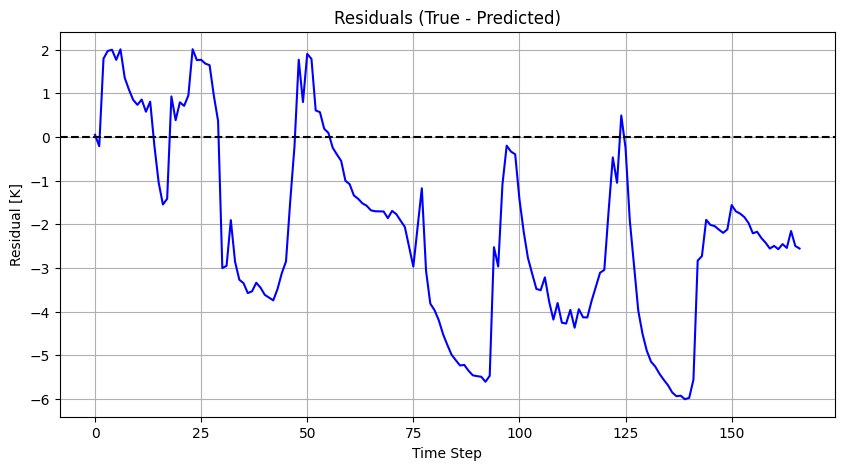

In [4]:
from models import *
from simulate import *
from plot import *

# --- Bounds ---
bounds_1r1c = {
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "Ain": (0.001, 0.3 * surface_area)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="1R1C",
    bounds=bounds_1r1c,
    show_plot=True
)
last_index = max(model.T_in.index_set())

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="1R1C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


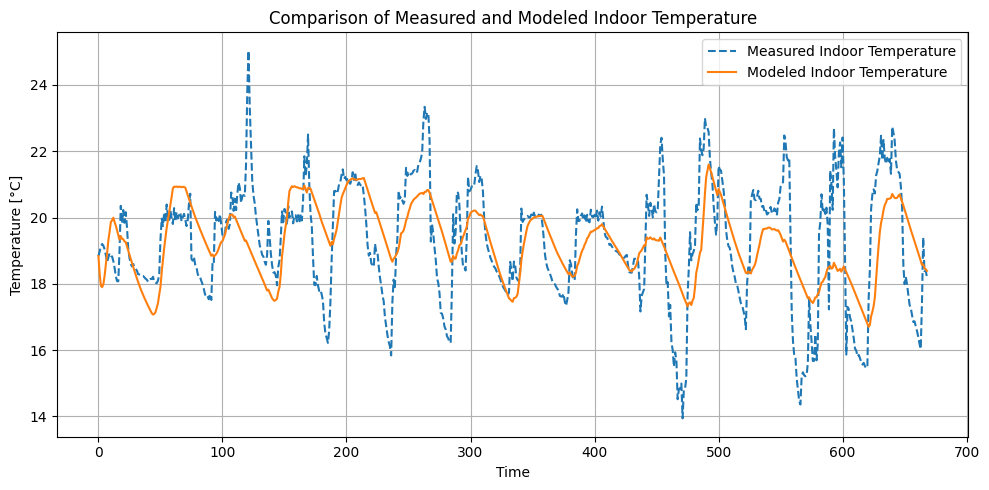

1.4994885362021335


In [41]:
from models import *
from simulate import *
from plot import *

# --- Bounds ---
bounds_3r2c = {
    "R_in_e": (0.005, 1),
    "R_e_a": (0.005, 1),
    "R_in_a": (0.005, 1),
    "C_in": (1e6, 5e9),
    "C_e": (1e6, 5e9),
    "Ain": (0.0001, 0.2 * surface_area),
    "Ae": (0.0001, 0.2 * surface_area),
    "fh": (0,1)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="3R2C",
    bounds=bounds_3r2c,
    show_plot=True
)
print(parameters['Objective'])

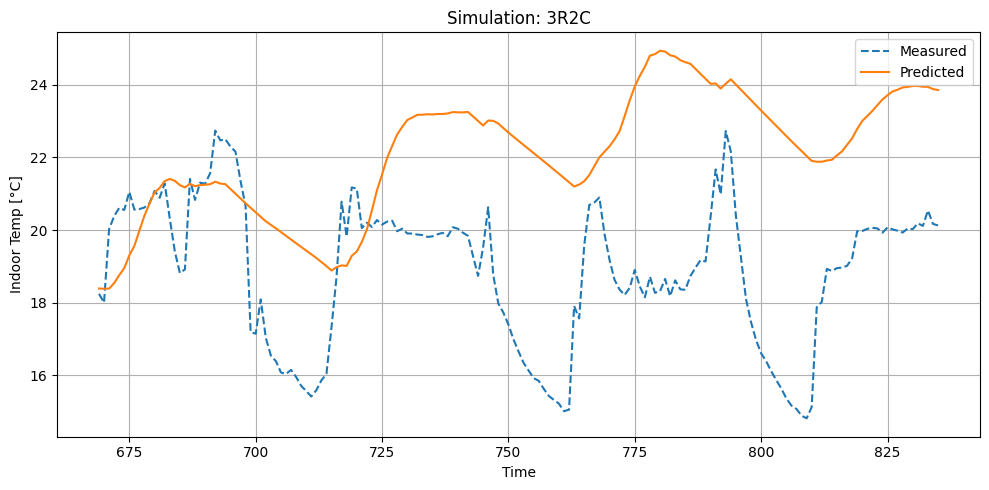

Validation RMSE: 4.0373


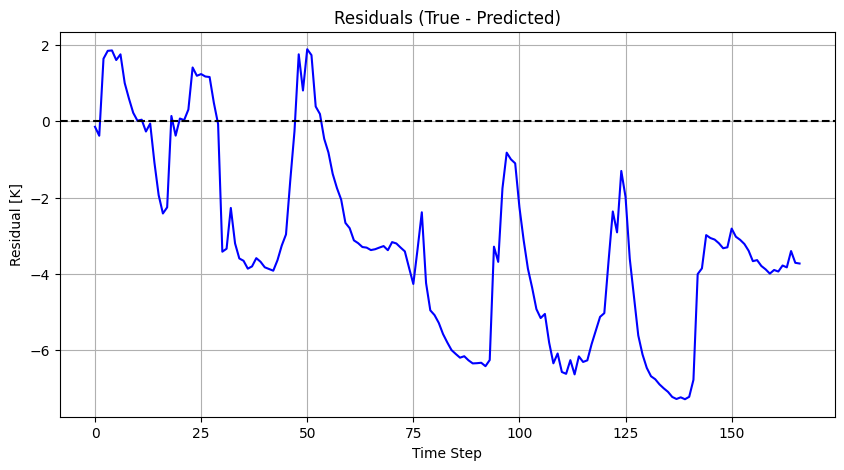

In [42]:
last_index = max(model.T_in.index_set())

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="3R2C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [43]:
from models import *  
from train import *  

best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="3R2C",    # ➔ Select the model type you want to train
    bounds=bounds_3r2c,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=10,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)
all_trials_3r2c=all_trials.copy()

[Trial 1] RMSE = 1.7195, Init: {'R_in_e': 0.5961600617753745, 'R_e_a': 0.3839864023478664, 'R_in_a': 0.9700648258255302, 'C_in': 4210752496.755408, 'C_e': 4191805194.850978, 'Ain': 37495.4528367283, 'Ae': 33185.56024553126, 'fh': 0.27340707193070624}
 parameters: {'R_in_e': 0.005000225877219295, 'R_e_a': 0.005000851941401361, 'R_in_a': 0.005000009880916697, 'C_in': 4210750685.2795005, 'C_e': 4191805192.8317814, 'Ain': 1334.8529054032267, 'Ae': 9166.65004823538, 'fh': 0.999999844652109, 'Objective': 1.7195350206591322}
[Trial 2] RMSE = 1.7211, Init: {'R_in_e': 0.061093619167672475, 'R_e_a': 0.8653987643737779, 'R_in_a': 0.8138365040844272, 'C_in': 4998588648.757367, 'C_e': 4983187548.532453, 'Ain': 44434.53649266702, 'Ae': 61518.99323754209, 'fh': 0.944765729882428}
 parameters: {'R_in_e': 0.0050002834747069815, 'R_e_a': 0.0050011256064548095, 'R_in_a': 0.005000012861399273, 'C_in': 4677726351.782222, 'C_e': 4999991912.748181, 'Ain': 1466.1224763515283, 'Ae': 12873.961122650873, 'fh': 0

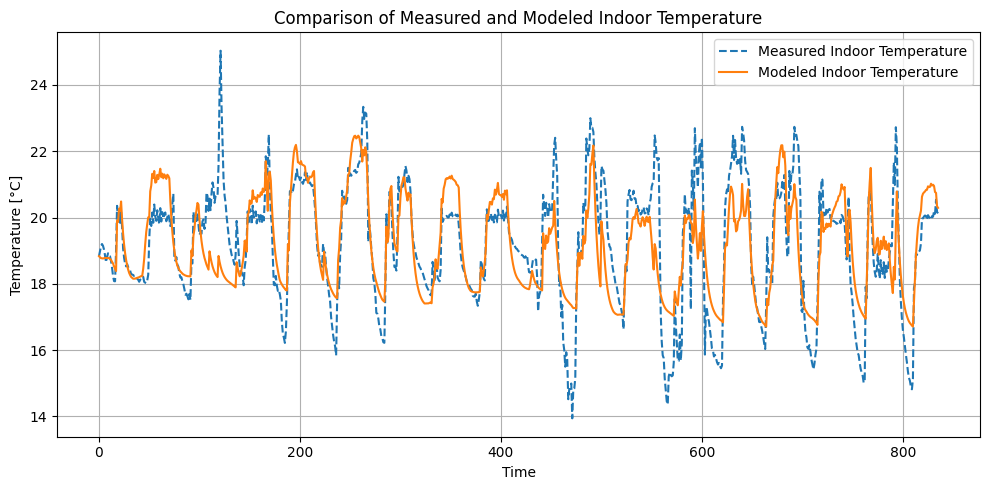

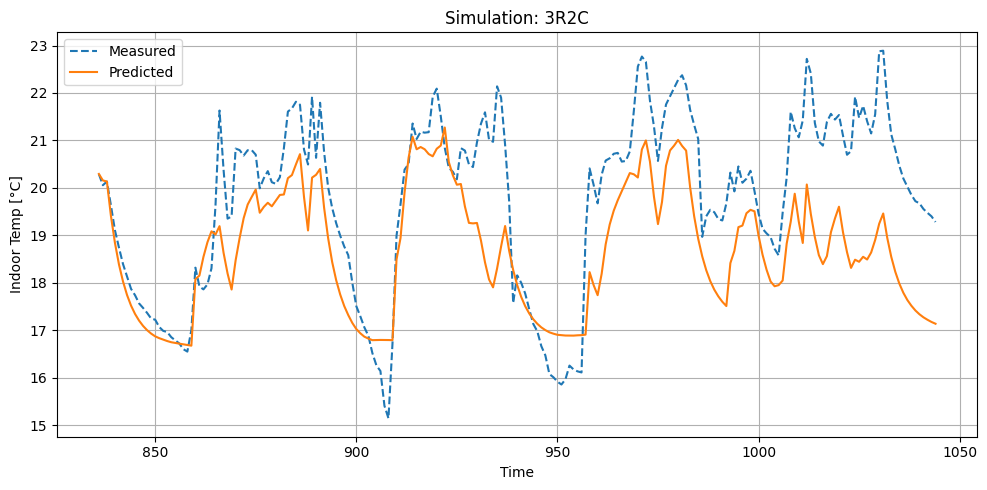

Validation RMSE: 1.5379


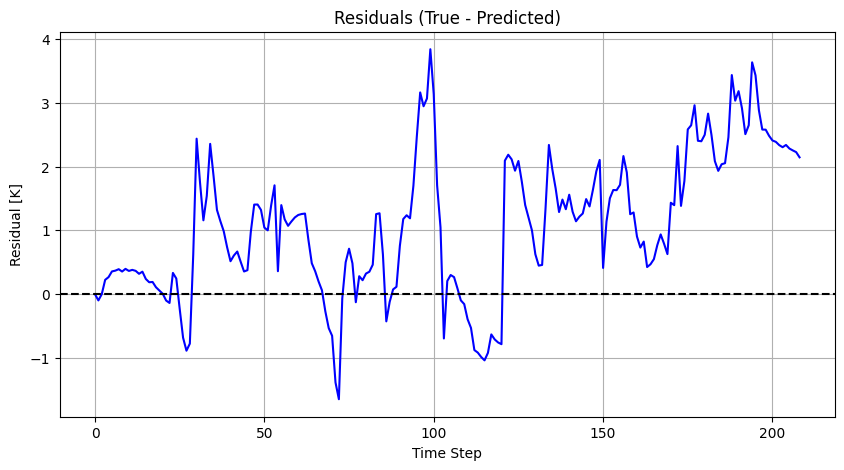

In [36]:
from models import *
from simulate import *
from plot import *

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="3R2C",
    bounds=bounds_3r2c,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="3R2C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


# 4R2C

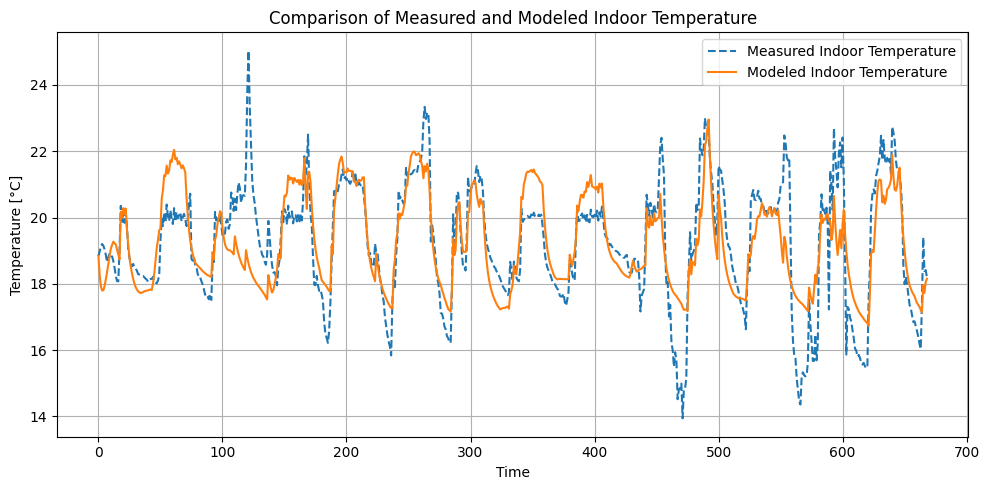

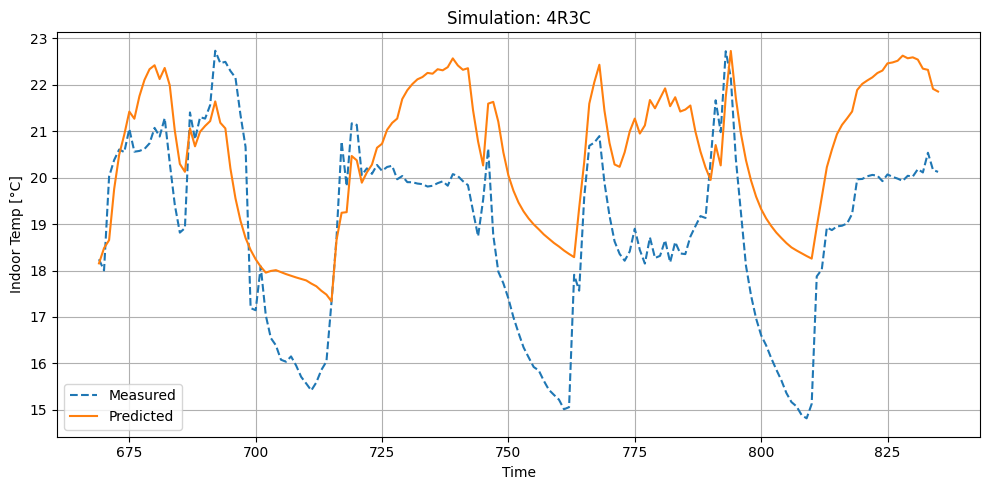

Validation RMSE: 2.0961


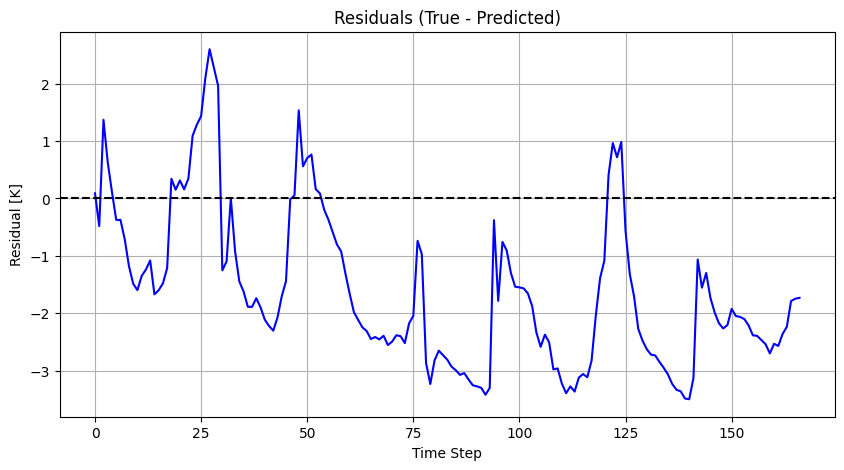

In [45]:
from models import *
from simulate import *
from plot import *

# --- Bounds ---
bounds_4r3c = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * surface_area),
    "Ain": (0.0001, 0.3 * surface_area),
    "Ae": (0.0001, 0.3 * surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="4R3C",
    bounds=bounds_4r3c,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tint": model.T_int[last_index](),"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="4R3C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [46]:
from models import *  
from train import *  

best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="4R3C",    # ➔ Select the model type you want to train
    bounds=bounds_4r3c,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=10,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)
all_trials_4r3c=all_trials.copy()

[Trial 1] RMSE = 1.5374, Init: {'R_int_in': 0.17059719294602022, 'R_in_e': 0.2800331583538947, 'R_e_a': 0.17865646330819332, 'R_in_a': 0.0905251286895415, 'C_int': 61373172.504979685, 'C_in': 231036449.49472362, 'C_e': 104119258.7408093, 'Aint': 43712.38338934207, 'Ain': 60410.072552241094, 'Ae': 82847.37946648436, 'fh_int': 0.039312139841098936, 'fh_in': 0.7994103989090426, 'fh_e': 0.6279003894909078}
 parameters: {'R_int_in': 0.1740405779672111, 'R_in_e': 0.0019999901378656374, 'R_e_a': 0.001999991241614026, 'R_in_a': 0.0019999901602422007, 'C_int': 152955520.7792273, 'C_in': 128077010.36837359, 'C_e': 100500536.61877386, 'Aint': 0.0010505033657529131, 'Ain': 104.98185379502532, 'Ae': 53.28760600167735, 'fh_int': 0.5314160203010492, 'fh_in': 0.46858395392861124, 'fh_e': 2.577033961415672e-08, 'Objective': 1.5373744379689203}
[Trial 2] RMSE = 1.6205, Init: {'R_int_in': 0.08359551388497416, 'R_in_e': 0.8738314668585637, 'R_e_a': 0.9210306557307496, 'R_in_a': 0.06295580393515401, 'C_int

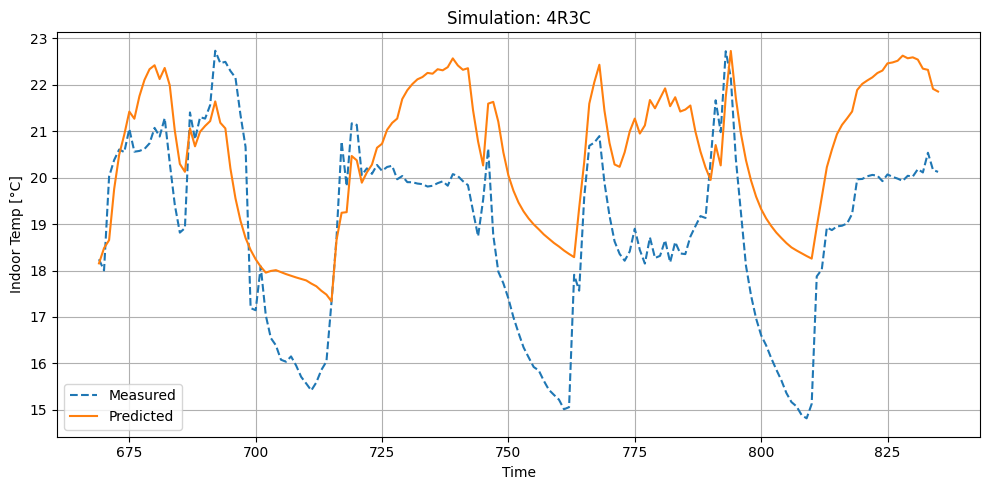

Validation RMSE: 2.0961


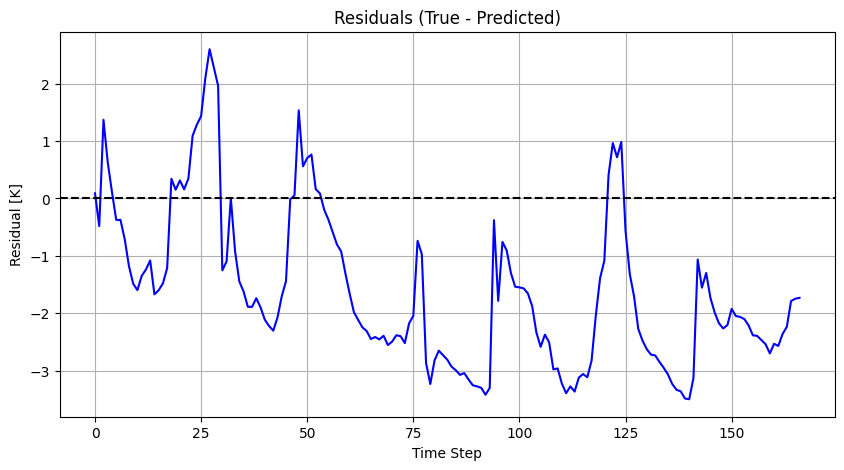

In [ ]:
from models import *
from simulate import *
from plot import *

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="4R3C",
    bounds=bounds_4r3c,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tint": model.T_int[last_index](),"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="4R3C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)